# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 21-11-2024 (latest update)

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
#from scipy.special import erfc                         # Error function, to get integral of Gaussian

Options for the program: 

In [2]:
blinded = True            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements. This is a good way of working, as we then don't get affected by prior beliefs. Note that a different blinding constant is added for the 30cm ruler and 2m folding rule measurements, so that only after unblinding can the correspondence between the two be considered as a vital cross check.

In [3]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [4]:
infiles = ["data_TableMeasurements2024.txt",
           "data_TableMeasurements2023.txt",
           "data_TableMeasurements2022.txt",
           "data_TableMeasurements2021.txt",
           "data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files (and print the values as a cross check):

In [5]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    # Note that blinding is applied before storing the values read:
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total
print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")



Read all 16 file(s) which included 913 measurements. 



### First thing: Plot the data!

It is paramount that one plots data - it is the only way to get a good sense of it.

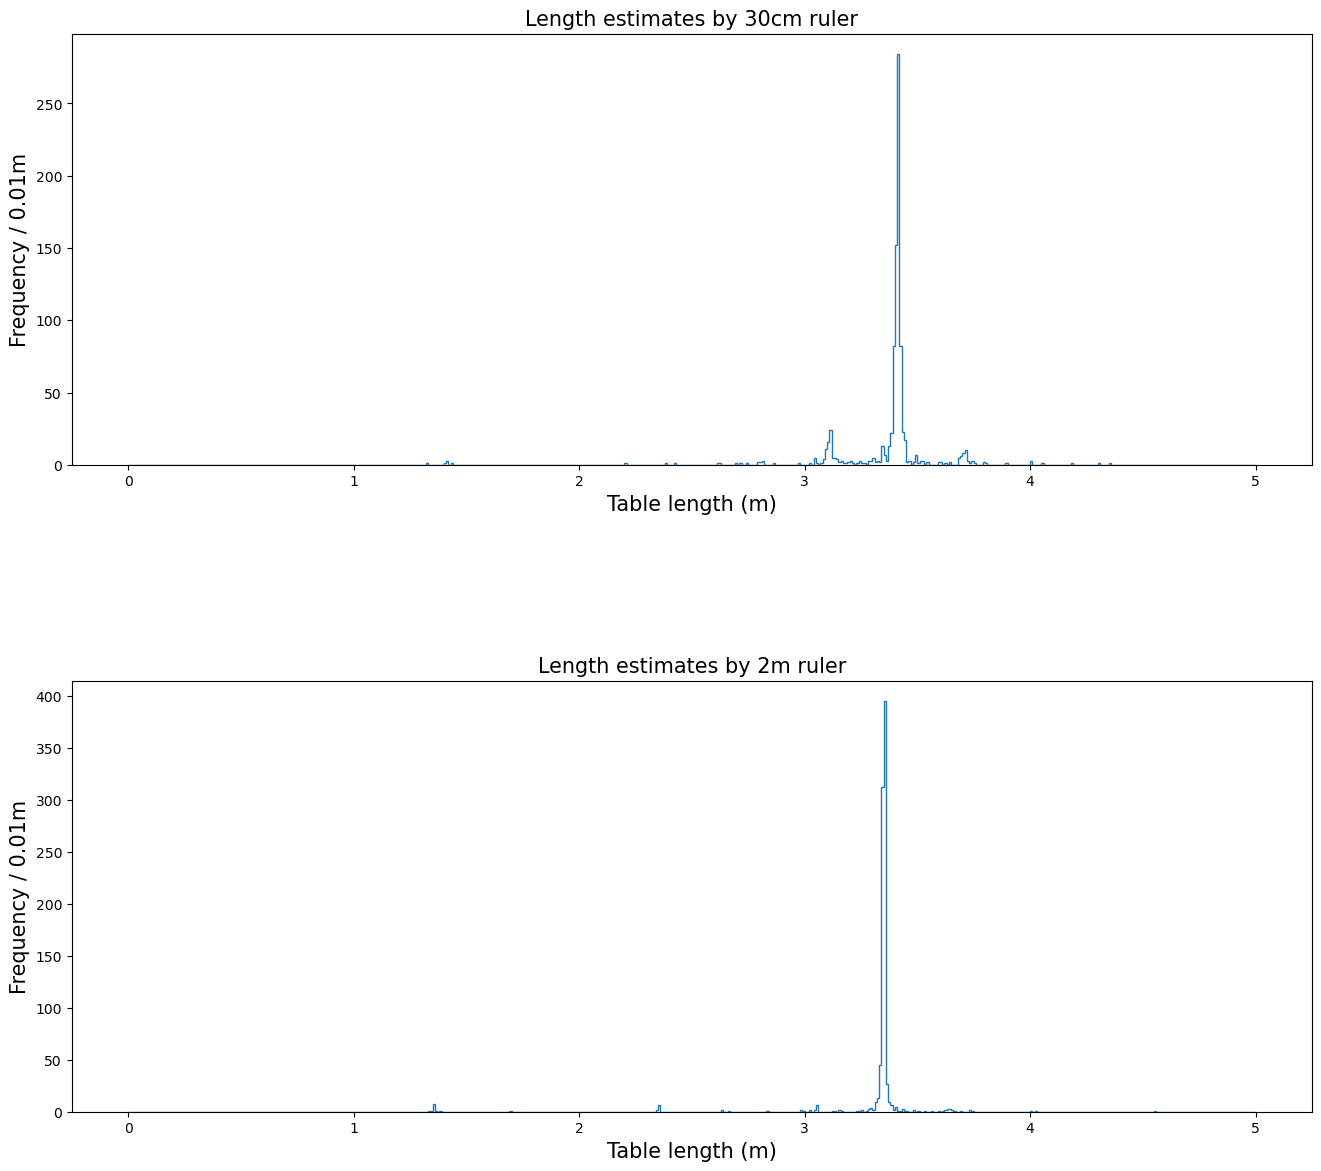

In [6]:
# Carefully consider binning - this might have to be changed, and subplots/inserts are defintely worth considering!
Nbins = 500
minL = 0.0
maxL = 5.0
binwidth = (maxL-minL)/Nbins

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)

hist_L2m = ax_L2m.hist(L2m, bins=Nbins, range=(minL, maxL), histtype='step', label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)

fig_raw.tight_layout;

In [7]:
print(f"  Initial estimate of raw data (30 cm ruler):    " +
      f"  {np.mean(L30cm):.3f} +- {np.std(L30cm, ddof=1)/np.sqrt(len(L30cm)):.3f} m " +
      f"  (Std = {np.std(L30cm, ddof=1):.3f})   (Nmeasurements = {len(L30cm):3d})")
print(f"  Initial estimate of raw data (2m folding rule):" +
      f"  {np.mean(L2m):.3f} +- {np.std(L2m, ddof=1)/np.sqrt(len(L2m)):.3f} m " +
      f"  (Std = {np.std(L2m, ddof=1):.3f})   (Nmeasurements = {len(L2m):3d})")

  Initial estimate of raw data (30 cm ruler):      3.375 +- 0.008 m   (Std = 0.232)   (Nmeasurements = 913)
  Initial estimate of raw data (2m folding rule):  3.306 +- 0.011 m   (Std = 0.329)   (Nmeasurements = 913)


### Next steps:

From the above, you should by now be aware, that there is definitely room for improvement, due to some poor measurement. You want to exclude (or correct?) these, but remember, you should be able to argue for each and every point you remove or correct.

In fact, make sure that PRINT OUT EVERY MEASUREMENT THAT YOU EXCLUDE, along with numbers arguing their case! Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines.

It is now up to you to select in (based on solid **quantified** arguments) the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

# Fitting analysis strategy:

Instead of rejecting data points, one might instead choose to model all the data, and thus extract the table length from a fit.

This approach requires that fitting the data well seems feasible, and building a good model can only be done in steps, such as:
1. Consider the central peak, and determine what PDF matches its distribution (Gaussian? Double Gaussian? Other?)
2. Extend the fit to have three peaks instead of just a single.
3. Expand the fit futher to incorporate potential inter-peak data.

Once a working ChiSquare fit is in place, one could continue the improvement by changing the fit into an unbinned likelihood fit, and check if this changes anything and/or adds to the precision.

## Single peak fits:

In [8]:
# Single Gaussian:
def func_G1(x, N, mu, sigma) :
    norm = 1.0 / np.sqrt(2.0*np.pi) / sigma
    z = (x - mu) / sigma
    return N * binwidth * norm * np.exp(-0.5*z*z)
    
# Double Gaussian with common mean:
def func_G2(x, N, mu, frac, sigma1, sigma2) :
    norm1 = 1.0 / np.sqrt(2.0*np.pi) / sigma1
    z1 = (x - mu) / sigma1
    norm2 = 1.0 / np.sqrt(2.0*np.pi) / sigma2
    z2 = (x - mu) / sigma2
    return N * binwidth * (frac * norm1 * np.exp(-0.5*z1*z1) + (1.0-frac) * norm2 * np.exp(-0.5*z2*z2))

# Lorentian distribution:
def func_Cauchy(x, N, mu, gamma) :
    return N * binwidth * gamma / (np.pi * (gamma**2 + (x-mu)**2))

In [9]:
Nbins = 40
xmin, xmax = 3.3, 3.5
binwidth = (xmax-xmin)/Nbins

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(L30cm, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)

# Select only non-zero bins:
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])

In [10]:
chi2fit_G1 = cost.LeastSquares(x, y, sy, func_G1)
mfit_G1 = Minuit(chi2fit_G1, N=700, mu=3.41, sigma=0.008)
mfit_G1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 117.4 (χ²/ndof = 3.7)      │              Nfcn = 74               │
│ EDM = 1.61e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    607    │    25     │            │            │         │         │       │
│ 1 │ mu    │  3.4112   │  0.0005   │            │            │         │         │       │
│ 2 │ sigma │  10.8e-3  │  0.5e-3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        N       mu    sigma │
├───────┼────────────────────────────┤
│     N │      607 -1.56e-6 19.02e-6 │
│    mu │ -1.56e-6 2.07e-07 -0.05e-6 │
│ sigma │ 19.02e-6 -0.05e-6 2.31e-07 │
└───────┴────────────────────────────┘

In [11]:
chi2fit_G2 = cost.LeastSquares(x, y, sy, func_G2)
mfit_G2 = Minuit(chi2fit_G2, N=700, mu=3.41, frac=0.8, sigma1=0.005, sigma2=0.018)
mfit_G2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.5 (χ²/ndof = 2.4)       │              Nfcn = 147              │
│ EDM = 1.11e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N      │    656    │    25     │            │            │         │         │       │
│ 1 │ mu     │  3.4120   │  0.0005   │            │            │         │         │       │
│ 2 │ frac   │   0.70    │   0.12    │            │            │         │         │       │
│ 3 │ sigma1 │  0.0079   │  0.0013   │            │            │         │         │       │
│ 4 │ sigma2 │   0.024   │   0.006   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────┐
│        │         N        mu      frac    sigma1    sigma2 │
├────────┼───────────────────────────────────────────────────┤
│      N │       645 -366.6e-6     0.166 1.8179e-3  10.54e-3 │
│     mu │ -366.6e-6     3e-07 -33.82e-6  -0.44e-6  -1.60e-6 │
│   frac │     0.166 -33.82e-6    0.0139  138.3e-6   0.67e-3 │
│ sigma1 │ 1.8179e-3  -0.44e-6  138.3e-6   1.6e-06    6.8e-6 │
│ sigma2 │  10.54e-3  -1.60e-6   0.67e-3    6.8e-6  3.66e-05 │
└────────┴───────────────────────────────────────────────────┘

In [12]:
chi2fit_Cauchy = cost.LeastSquares(x, y, sy, func_Cauchy)
mfit_Cauchy = Minuit(chi2fit_Cauchy, N=700, mu=3.41, gamma=0.01)
mfit_Cauchy.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.09 (χ²/ndof = 1.9)      │              Nfcn = 66               │
│ EDM = 5.55e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    702    │    27     │            │            │         │         │       │
│ 1 │ mu    │  3.4126   │  0.0004   │            │            │         │         │       │
│ 2 │ gamma │  6.7e-3   │  0.4e-3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────┐
│       │          N         mu      gamma │
├───────┼──────────────────────────────────┤
│     N │        751 -145.04e-6  903.68e-6 │
│    mu │ -145.04e-6   1.53e-07   -0.03e-6 │
│ gamma │  903.68e-6   -0.03e-6   1.38e-07 │
└───────┴──────────────────────────────────┘

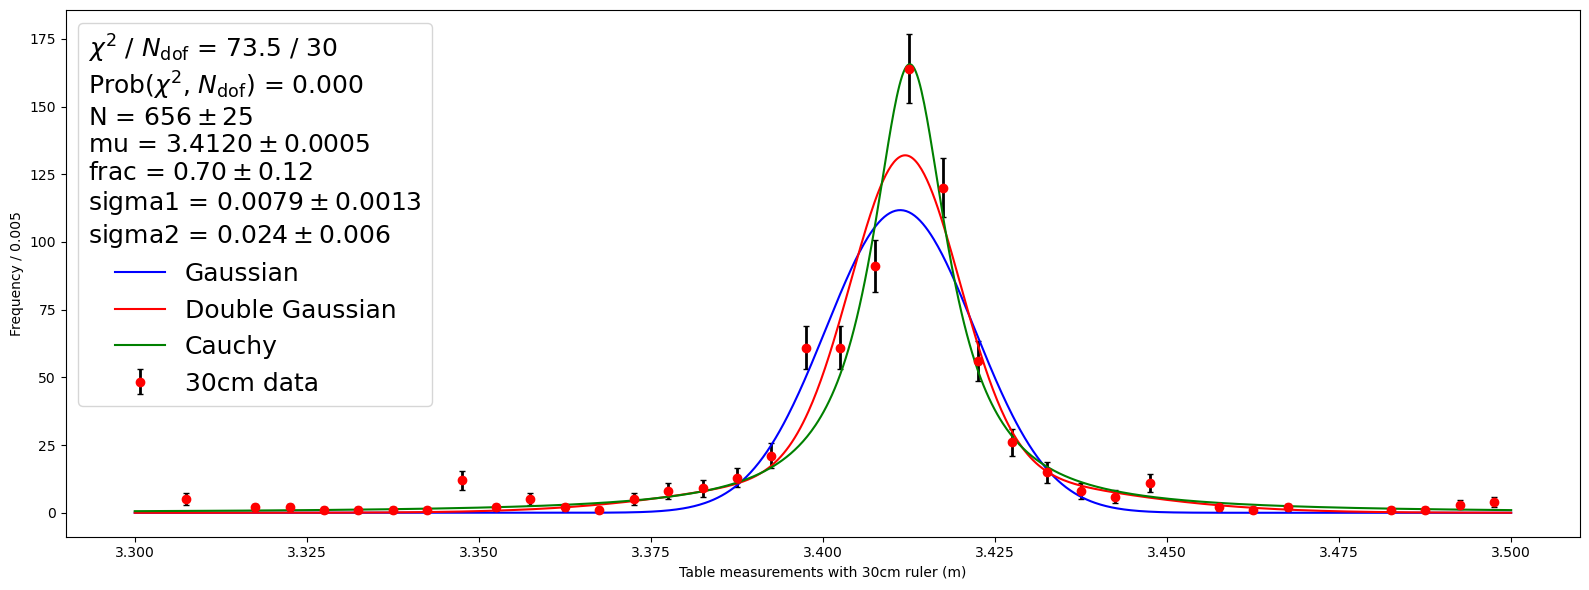

In [13]:
# Now plot the histogram with uncertainties along with the fit function:
fig2, ax2 = plt.subplots(figsize=(16,6))
ax2.errorbar(x, y, sy, label='30cm data', fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
x_axis = np.linspace(xmin, xmax, 1000)
ax2.plot(x_axis, func_G1(x_axis, *mfit_G1.values[:]), '-b', label="Gaussian")
ax2.plot(x_axis, func_G2(x_axis, *mfit_G2.values[:]), '-r', label="Double Gaussian")
ax2.plot(x_axis, func_Cauchy(x_axis, *mfit_Cauchy.values[:]), '-g', label="Cauchy")
ax2.set(title ="", xlabel="Table measurements with 30cm ruler (m)", ylabel="Frequency / 0.005")

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {mfit_G2.fval:.1f} / {np.sum(y > 0) - mfit_G2.nfit}",
            f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {stats.chi2.sf(mfit_G2.fval, np.sum(y > 0) - mfit_G2.nfit):.3f}"]
for p, v, e in zip(mfit_G2.parameters, mfit_G2.values[:], mfit_G2.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")
ax2.legend(loc='upper left', title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');

fig2.tight_layout()
if (save_plots) :
    fig2.savefig("TableMeasurements_FitAnalysis_30cm_1gauss_2gauss_cauchy.pdf")

In [14]:
# Uncertainty on mean from the three fits:
print(f"  G1:     Uncertainty on mean = {mfit_G1.values[1]:7.5f} +- {mfit_G1.errors[1]:7.5f}      Chi2 = {mfit_G1.fval:5.1f}")
print(f"  G2:     Uncertainty on mean = {mfit_G2.values[1]:7.5f} +- {mfit_G2.errors[1]:7.5f}      Chi2 = {mfit_G2.fval:5.1f}")
print(f"  Cauchy: Uncertainty on mean = {mfit_Cauchy.values[1]:7.5f} +- {mfit_Cauchy.errors[1]:7.5f}      Chi2 = {mfit_Cauchy.fval:5.1f}")

  G1:     Uncertainty on mean = 3.41123 +- 0.00045      Chi2 = 117.4
  G2:     Uncertainty on mean = 3.41195 +- 0.00055      Chi2 =  73.5
  Cauchy: Uncertainty on mean = 3.41261 +- 0.00039      Chi2 =  62.1


## Conclusions from single peak fit:

None of the models are very good, but **the double Gaussian is clearly better than the single Gaussian**, as two parameters extra yields a drop in Chi2 from 117 to 73 (i.e. 38 down, where one would expect a drop of 2, if they were useless). Furthermore, **the Cauchy distribution performs best**, as it has a lower ChiSquare using _fewer parameters_.

Notice, that the covariance matrix between the fitting parameters has large correlations for the double Gaussian. This is natural, as the changing of the two widths and the fraction between them affects each other. Occationally, one might be forced to fix one of the three parameters, in order to make the fit converge.

In [15]:
# Three double Gaussians with common, but shifted, mean:
def func_G2_3peaks(x, N, frac_low, frac_high, mu, frac, sigma1, sigma2) :

    # Given common widths, the normalisations are the same for all three peaks:
    norm1 = 1.0 / np.sqrt(2.0*np.pi) / sigma1
    norm2 = 1.0 / np.sqrt(2.0*np.pi) / sigma2

    # z-values for each peak - note the constant shift, and that there are only two fit parameters:
    z1 = (x - mu) / sigma1
    z2 = (x - mu) / sigma2
    z1_low  = ((x + 0.300) - mu) / sigma1
    z2_low  = ((x + 0.300) - mu) / sigma2
    z1_high = ((x - 0.300) - mu) / sigma1
    z2_high = ((x - 0.300) - mu) / sigma2

    # The three Gaussian double peaks:
    G2      = frac * norm1 * np.exp(-0.5 * z1**2)      + (1.0-frac) * norm2 * np.exp(-0.5 * z2**2)
    G2_low  = frac * norm1 * np.exp(-0.5 * z1_low**2)  + (1.0-frac) * norm2 * np.exp(-0.5 * z2_low**2)
    G2_high = frac * norm1 * np.exp(-0.5 * z1_high**2) + (1.0-frac) * norm2 * np.exp(-0.5 * z2_high**2)

    # Return the full expression:
    return N * binwidth * ((1.0-frac_low-frac_high) * G2 + frac_low * G2_low + frac_high * G2_high)

In [16]:
# Three Cauchy with common, but shifted, mean:
def func_Cauchy_3peaks(x, N, frac_low, frac_high, mu, gamma) :
    
    # The three Gaussian double peaks:
    Cauchy      = gamma / (np.pi * (gamma**2 + (x - mu)**2))
    Cauchy_low  = gamma / (np.pi * (gamma**2 + ((x + 0.300) - mu)**2))
    Cauchy_high = gamma / (np.pi * (gamma**2 + ((x - 0.300) - mu)**2))

    # Return the full expression:
    return N * binwidth * ((1.0-frac_low-frac_high) * Cauchy + frac_low * Cauchy_low + frac_high * Cauchy_high)

In [17]:
Nbins = 160
xmin, xmax = 3.0, 3.8
binwidth = (xmax-xmin)/Nbins

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(L30cm, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)

# Select only non-zero bins:
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])

chi2fit_3G2 = cost.LeastSquares(x, y, sy, func_G2_3peaks)
mfit_3G2 = Minuit(chi2fit_3G2, N=740, frac_low=0.08, frac_high=0.05, mu=3.411, frac=0.7, sigma1=0.008, sigma2=0.023)
# mfit_3G2.fixto("frac", 0.7)    # Fixing a parameter, if needed (it is with half the number of bins)
mfit_3G2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 111.9 (χ²/ndof = 1.2)      │              Nfcn = 504              │
│ EDM = 1.16e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N         │  0.97e3   │  0.13e3   │            │            │         │         │       │
│ 1 │ frac_low  │   0.058   │   0.011   │            │            │         │         │       │
│ 2 │ frac_high │   0.014   │   0.007   │            │            │         │         │       │
│ 3 │ mu        │  3.4111   │  0.0005   │            │            │         │         │       │
│ 4 │ frac      │   0.65    │   0.09    │            │            │         │         │       │
│ 5 │ sigma1    │  10.2e-3  │  0.5e-3   │            │            │         │         │       │
│ 6 │ sigma2    │   0.42    │   0.21    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬──────────────────────────────────────────────────────────────────────────────┐
│           │          N   frac_low  frac_high         mu       frac     sigma1     sigma2 │
├───────────┼──────────────────────────────────────────────────────────────────────────────┤
│         N │   1.79e+04 -316.82e-3 -249.56e-3  874.83e-6    -11.496 1.20216e-3      26.34 │
│  frac_low │ -316.82e-3   0.000124          0   -0.77e-6    0.24e-3   -0.03e-6   -0.47e-3 │
│ frac_high │ -249.56e-3          0      5e-05   -0.06e-6    0.19e-3    0.34e-6   -0.37e-3 │
│        mu │  874.83e-6   -0.77e-6   -0.06e-6   2.04e-07   -0.87e-6   -0.06e-6    0.82e-6 │
│      frac │    -11.496    0.24e-3    0.19e-3   -0.87e-6     0.0081    0.27e-6     -0.018 │
│    sigma1 │ 1.20216e-3   -0.03e-6    0.34e-6   -0.06e-6    0.27e-6   2.07e-07    4.14e-6 │
│    sigma2 │      26.34   -0.47e-3   -0.37e-3    0.82e-6     -0.018    4.14e-6     0.0425 │
└───────────┴──────────────────────────────────────────────────────────────────────────────┘

In [18]:
chi2fit_3Cauchy = cost.LeastSquares(x, y, sy, func_Cauchy_3peaks)
mfit_3Cauchy = Minuit(chi2fit_3Cauchy, N=740, frac_low=0.08, frac_high=0.05, mu=3.411, gamma=0.01)
mfit_3Cauchy.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 127.8 (χ²/ndof = 1.4)      │              Nfcn = 116              │
│ EDM = 0.000109 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N         │    791    │    29     │            │            │         │         │       │
│ 1 │ frac_low  │   0.079   │   0.010   │            │            │         │         │       │
│ 2 │ frac_high │   0.024   │   0.006   │            │            │         │         │       │
│ 3 │ mu        │  3.4124   │  0.0004   │            │            │         │         │       │
│ 4 │ gamma     │  7.0e-3   │  0.4e-3   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬────────────────────────────────────────────────────────┐
│           │          N   frac_low  frac_high         mu      gamma │
├───────────┼────────────────────────────────────────────────────────┤
│         N │        836    3.97e-3    5.79e-3 -131.36e-6  865.70e-6 │
│  frac_low │    3.97e-3   0.000105         -0   -0.63e-6    0.33e-6 │
│ frac_high │    5.79e-3         -0   3.88e-05    0.30e-6    0.18e-6 │
│        mu │ -131.36e-6   -0.63e-6    0.30e-6   1.42e-07   -0.04e-6 │
│     gamma │  865.70e-6    0.33e-6    0.18e-6   -0.04e-6   1.47e-07 │
└───────────┴────────────────────────────────────────────────────────┘

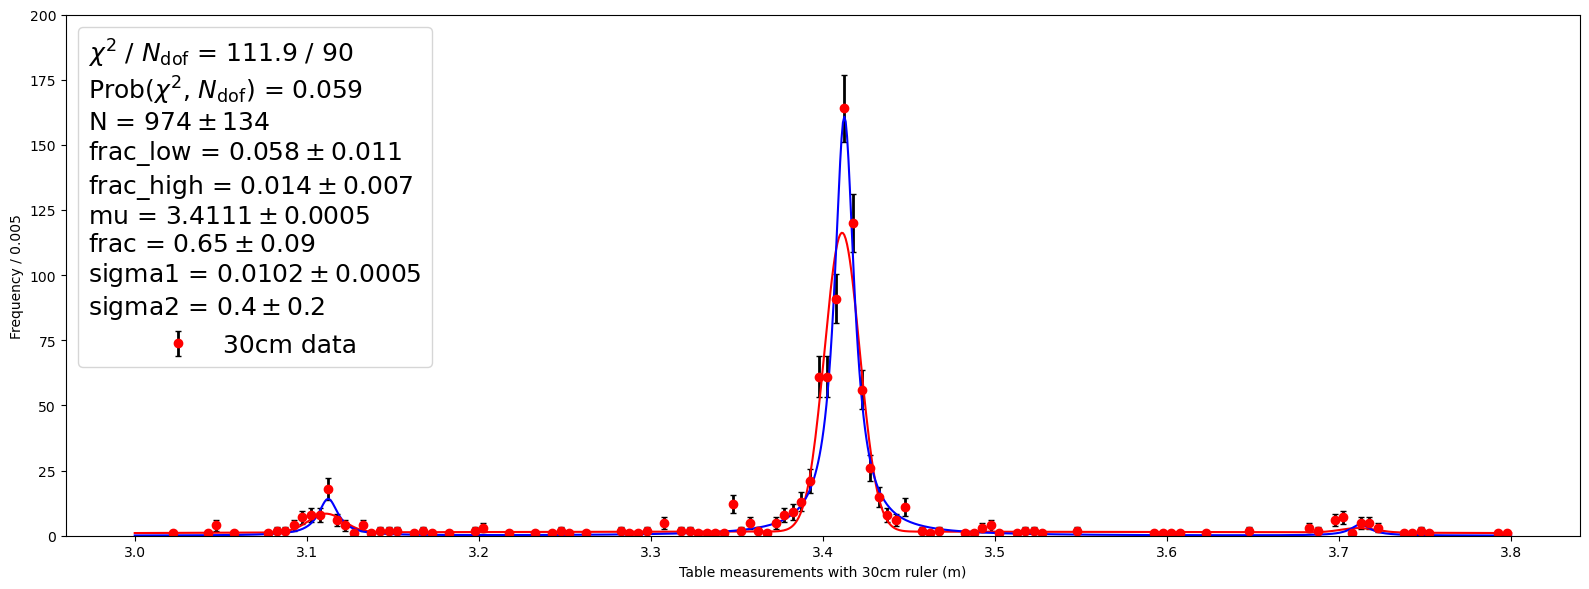

In [19]:
# Now plot the histogram with uncertainties along with the fit function:
fig3, ax3 = plt.subplots(figsize=(16,6))
ax3.errorbar(x, y, sy, label='30cm data', fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
x_axis = np.linspace(xmin, xmax, 1000)
ax3.plot(x_axis, func_G2_3peaks(x_axis, *mfit_3G2.values[:]), '-r')      # Note how we can "smartly" input the fit values!
ax3.plot(x_axis, func_Cauchy_3peaks(x_axis, *mfit_3Cauchy.values[:]), '-b')
ax3.set(title ="", xlabel="Table measurements with 30cm ruler (m)", ylabel="Frequency / 0.005")

# Plot the fit function on top of data with "given" parameters to check correspondence:
# ax3.plot(x_axis, func_G2_3peaks(x_axis, 700, 0.1, 0.05, 3.41, 0.7, 0.008, 0.024), '-b')

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {mfit_3G2.fval:.1f} / {np.sum(y > 0) - mfit_3G2.nfit}",
            f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {stats.chi2.sf(mfit_3G2.fval, np.sum(y > 0) - mfit_3G2.nfit):.3f}"]
for p, v, e in zip(mfit_3G2.parameters, mfit_3G2.values[:], mfit_3G2.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")
ax3.legend(loc='upper left', title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
ax3.set_ylim(0.0,200.0)
    
fig3.tight_layout()
if (save_plots) :
    fig3.savefig("TableMeasurements_FitAnalysis_30cm_3peaks_eachof_2gauss.pdf")

In [20]:
# Uncertainty on mean from the two fits:
print(f"  3 x G2:     Uncertainty on mean = {mfit_3G2.values[1]:7.5f} +- {mfit_3G2.errors[1]:7.5f}      Chi2 = {mfit_3G2.fval:5.1f}")
print(f"  3 x Cauchy: Uncertainty on mean = {mfit_3Cauchy.values[1]:7.5f} +- {mfit_3Cauchy.errors[1]:7.5f}      Chi2 = {mfit_3Cauchy.fval:5.1f}")

  3 x G2:     Uncertainty on mean = 0.05823 +- 0.01113      Chi2 = 111.9
  3 x Cauchy: Uncertainty on mean = 0.07854 +- 0.01024      Chi2 = 127.8


## Conclusions from triple peak fit:

The fits converge and gives semi-reasonable values. However, due to the far outliers, the double Gaussian fit gives a large value for sigma2 in order to model these outliers, rather than features of the peak! The Cauchy fit now has a worse ChiSquare, as it doesn't describe the side peaks well, nor perhaps the measurements in between the peaks.

A better model, which avoids this problem should have a separate PDF for the far outliers. One can either add a third Gaussian to each peak, or simply a constant on top. The latter is the simplest, so we start that way.

In [21]:
# Three double Gaussians with common, but shifted, mean, along with a "background" constant:
def func_G2_3peaks_const(x, N, frac_low, frac_high, mu, frac, sigma1, sigma2, c) :

    # Given common widths, the normalisations are the same for all three peaks:
    norm1 = 1.0 / np.sqrt(2.0*np.pi) / sigma1
    norm2 = 1.0 / np.sqrt(2.0*np.pi) / sigma2

    # z-values for each peak - note the constant shift, and that there are only two fit parameters:
    z1 = (x - mu) / sigma1
    z2 = (x - mu) / sigma2
    z1_low  = ((x + 0.300) - mu) / sigma1
    z2_low  = ((x + 0.300) - mu) / sigma2
    z1_high = ((x - 0.300) - mu) / sigma1
    z2_high = ((x - 0.300) - mu) / sigma2

    # The three Gaussian double peaks:
    G2      = frac * norm1 * np.exp(-0.5 * z1**2)      + (1.0-frac) * norm2 * np.exp(-0.5 * z2**2)
    G2_low  = frac * norm1 * np.exp(-0.5 * z1_low**2)  + (1.0-frac) * norm2 * np.exp(-0.5 * z2_low**2)
    G2_high = frac * norm1 * np.exp(-0.5 * z1_high**2) + (1.0-frac) * norm2 * np.exp(-0.5 * z2_high**2)

    # Return the full expression:
    return N * binwidth * ((1.0-frac_low-frac_high) * G2 + frac_low * G2_low + frac_high * G2_high) + c

In [22]:
# Three Cauchy with common, but shifted, mean:
def func_Cauchy_3peaks_const(x, N, frac_low, frac_high, mu, gamma, c) :
    
    # The three Gaussian double peaks:
    Cauchy      = gamma / (np.pi * (gamma**2 + (x - mu)**2))
    Cauchy_low  = gamma / (np.pi * (gamma**2 + ((x + 0.300) - mu)**2))
    Cauchy_high = gamma / (np.pi * (gamma**2 + ((x - 0.300) - mu)**2))

    # Return the full expression:
    return N * binwidth * ((1.0-frac_low-frac_high) * Cauchy + frac_low * Cauchy_low + frac_high * Cauchy_high) + c

In [23]:
chi2fit_3G2c = cost.LeastSquares(x, y, sy, func_G2_3peaks_const)
mfit_3G2c = Minuit(chi2fit_3G2c, N=740, frac_low=0.08, frac_high=0.05, mu=3.411, frac=0.7, sigma1=0.008, sigma2=0.023, c=1.0)
# mfit_3G2c.fixto("frac", 0.7)    # Fixing a parameter, if needed (it is with half the number of bins)
mfit_3G2c.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 89.47 (χ²/ndof = 1.0)      │              Nfcn = 199              │
│ EDM = 4.27e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N         │    668    │    26     │            │            │         │         │       │
│ 1 │ frac_low  │   0.058   │   0.011   │            │            │         │         │       │
│ 2 │ frac_high │   0.011   │   0.006   │            │            │         │         │       │
│ 3 │ mu        │  3.4121   │  0.0004   │            │            │         │         │       │
│ 4 │ frac      │   0.53    │   0.14    │            │            │         │         │       │
│ 5 │ sigma1    │  0.0062   │  0.0013   │            │            │         │         │       │
│ 6 │ sigma2    │  0.0162   │  0.0026   │            │            │         │         │       │
│ 7 │ c         │   1.30    │   0.15    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────────────────────────────────────────┐
│           │           N    frac_low   frac_high          mu        frac      sigma1      sigma2           c │
├───────────┼─────────────────────────────────────────────────────────────────────────────────────────────────┤
│         N │         699    37.89e-3     1.18e-3 -1.50781e-3       0.598   6.3654e-3   14.147e-3      -0.853 │
│  frac_low │    37.89e-3    0.000118           0    -0.77e-6     0.10e-3      1.0e-6        2e-6    -0.32e-3 │
│ frac_high │     1.18e-3           0    3.75e-05    -0.08e-6     0.05e-3      0.8e-6        1e-6    -0.24e-3 │
│        mu │ -1.50781e-3    -0.77e-6    -0.08e-6    2.01e-07   -28.07e-6    -0.30e-6    -0.49e-6    11.88e-6 │
│      frac │       0.598     0.10e-3     0.05e-3   -28.07e-6      0.0205    173.8e-6      343e-6      -0.005 │
│    sigma1 │   6.3654e-3      1.0e-6      0.8e-6    -0.30e-6    173.8e-6    1.68e-06      2.9e-6    -48.2e-6 │
│    sigma2 │   14.147e-3        2e-6        1e-6    -0.49e-6      343e-6      2.9e-6     6.9e-06     -115e-6 │
│         c │      -0.853    -0.32e-3    -0.24e-3    11.88e-6      -0.005    -48.2e-6     -115e-6      0.0234 │
└───────────┴─────────────────────────────────────────────────────────────────────────────────────────────────┘

In [24]:
chi2fit_3Cauchy_c = cost.LeastSquares(x, y, sy, func_Cauchy_3peaks_const)
mfit_3Cauchy_c = Minuit(chi2fit_3Cauchy_c, N=740, frac_low=0.08, frac_high=0.05, mu=3.411, gamma=0.01, c=1.0)
mfit_3Cauchy_c.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 106.8 (χ²/ndof = 1.2)      │              Nfcn = 153              │
│ EDM = 9.71e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N         │    733    │    31     │            │            │         │         │       │
│ 1 │ frac_low  │   0.068   │   0.011   │            │            │         │         │       │
│ 2 │ frac_high │   0.017   │   0.007   │            │            │         │         │       │
│ 3 │ mu        │  3.4126   │  0.0004   │            │            │         │         │       │
│ 4 │ gamma     │  6.3e-3   │  0.4e-3   │            │            │         │         │       │
│ 5 │ c         │   0.73    │   0.16    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────────────────────┐
│           │          N   frac_low  frac_high         mu      gamma          c │
├───────────┼───────────────────────────────────────────────────────────────────┤
│         N │        979   39.28e-3   28.98e-3 -530.80e-6 2.98076e-3     -1.922 │
│  frac_low │   39.28e-3   0.000121         -0   -0.67e-6    0.39e-6   -0.34e-3 │
│ frac_high │   28.98e-3         -0   4.39e-05    0.28e-6    0.24e-6   -0.23e-3 │
│        mu │ -530.80e-6   -0.67e-6    0.28e-6   1.44e-07   -0.03e-6    4.26e-6 │
│     gamma │ 2.98076e-3    0.39e-6    0.24e-6   -0.03e-6   1.38e-07  -21.61e-6 │
│         c │     -1.922   -0.34e-3   -0.23e-3    4.26e-6  -21.61e-6     0.0251 │
└───────────┴───────────────────────────────────────────────────────────────────┘

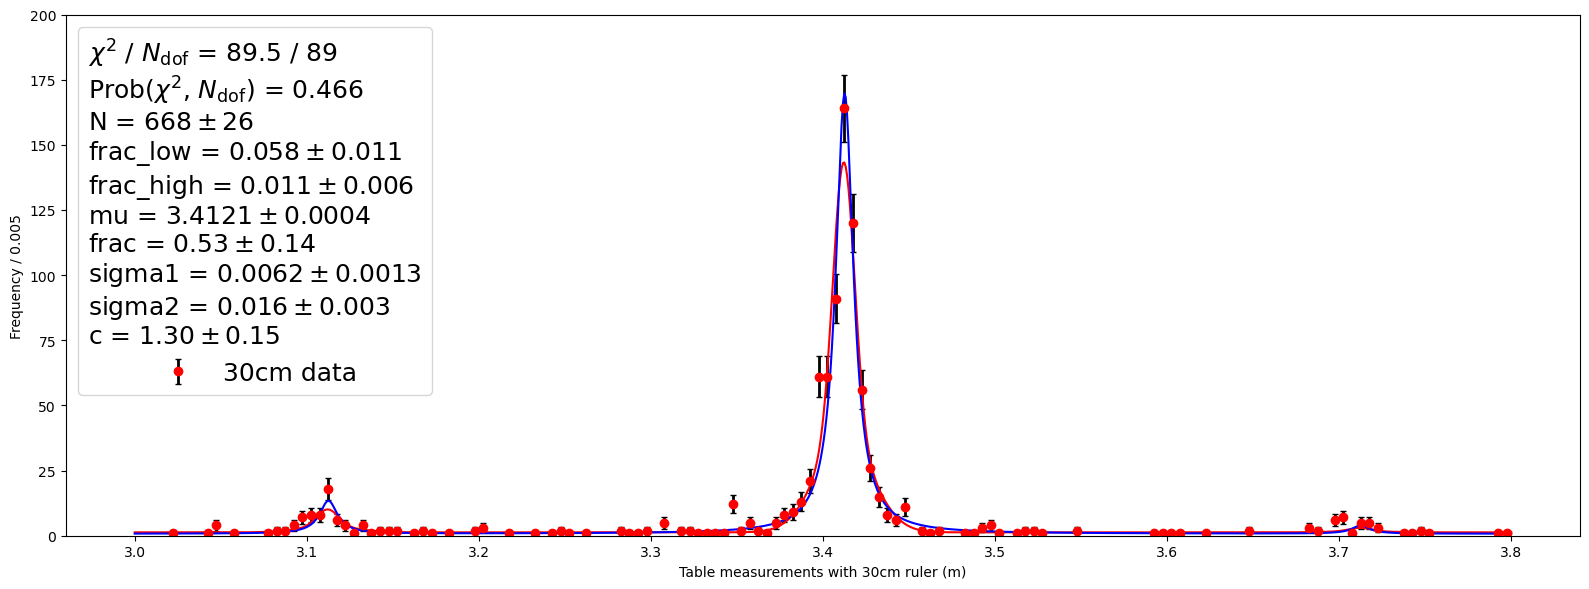

In [25]:
# Now plot the histogram with uncertainties along with the fit function:
fig4, ax4 = plt.subplots(figsize=(16,6))
ax4.errorbar(x, y, sy, label='30cm data', fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
x_axis = np.linspace(xmin, xmax, 1000)
ax4.plot(x_axis, func_G2_3peaks_const(x_axis, *mfit_3G2c.values[:]), '-r')      # Note how we can "smartly" input the fit values!
ax4.plot(x_axis, func_Cauchy_3peaks_const(x_axis, *mfit_3Cauchy_c.values[:]), '-b')
ax4.set(title ="", xlabel="Table measurements with 30cm ruler (m)", ylabel="Frequency / 0.005")

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {mfit_3G2c.fval:.1f} / {np.sum(y > 0) - mfit_3G2c.nfit}",
            f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {stats.chi2.sf(mfit_3G2c.fval, np.sum(y > 0) - mfit_3G2c.nfit):.3f}"]
for p, v, e in zip(mfit_3G2c.parameters, mfit_3G2c.values[:], mfit_3G2c.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")
ax4.legend(loc='upper left', title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
ax4.set_ylim(0.0,200.0)

# Plot the individual values at the bottom of the plot:
# ax4.plot(xmix, np.zeros_like(xmix), "|", alpha=0.1);

fig4.tight_layout()
if (save_plots) :
    fig4.savefig("TableMeasurements_FitAnalysis_30cm_3peaks_eachof_2gauss_const.pdf")

In [26]:
# Uncertainty on mean from the two fits:
print(f"  3 x G2 + c:     Uncertainty on mean = {mfit_3G2c.values[1]:7.5f} +- {mfit_3G2c.errors[1]:7.5f}")
print(f"  3 x Cauchy + c: Uncertainty on mean = {mfit_3Cauchy_c.values[1]:7.5f} +- {mfit_3Cauchy_c.errors[1]:7.5f}")

  3 x G2 + c:     Uncertainty on mean = 0.05759 +- 0.01086
  3 x Cauchy + c: Uncertainty on mean = 0.06820 +- 0.01102


## Conclusions on adding a constant to PDF:

With the addition of a constant term, the Gaussian PDFs are centered on the peaks, which they now describe reasonably well. The constant term incorporates the far outliers, and the ChiSquare value is good. All in all a good fit. The Cauchy fit didn't improve much, and now gives a larger uncertainty.

However, the statistics in most bins is very low, and many empty bins (which carries information) are not incorporated in the fit.

## Unbinned likelihood fit:

In [27]:
# Three double Gaussians with common, but shifted, mean, along with a "background" constant:
def func_G2_3peaks_const_llh(x, N, frac_low, frac_high, mu, frac, sigma1, sigma2, c) :

    # Given common widths, the normalisations are the same for all three peaks:
    norm1 = 1.0 / np.sqrt(2.0*np.pi) / sigma1
    norm2 = 1.0 / np.sqrt(2.0*np.pi) / sigma2

    # z-values for each peak - note the constant shift, and that there are only two fit parameters:
    z1 = (x - mu) / sigma1
    z2 = (x - mu) / sigma2
    z1_low  = ((x + 0.300) - mu) / sigma1
    z2_low  = ((x + 0.300) - mu) / sigma2
    z1_high = ((x - 0.300) - mu) / sigma1
    z2_high = ((x - 0.300) - mu) / sigma2

    # The three Gaussian double peaks:
    G2      = frac * norm1 * np.exp(-0.5 * z1**2)      + (1.0-frac) * norm2 * np.exp(-0.5 * z2**2)
    G2_low  = frac * norm1 * np.exp(-0.5 * z1_low**2)  + (1.0-frac) * norm2 * np.exp(-0.5 * z2_low**2)
    G2_high = frac * norm1 * np.exp(-0.5 * z1_high**2) + (1.0-frac) * norm2 * np.exp(-0.5 * z2_high**2)

    # Return the full expression (binwidth is included in order to be able to compare with binned plot):
    return N * binwidth * ((1.0-frac_low-frac_high) * G2 + frac_low * G2_low + frac_high * G2_high) + c

In [28]:
# Unbinned likelihood fit:
npL30cm = np.array(L30cm)
ubllhfit_3G2c = cost.UnbinnedNLL(npL30cm[(3.0 < npL30cm) & (npL30cm < 3.8)], func_G2_3peaks_const_llh)
mllhfit_3G2c = Minuit(ubllhfit_3G2c, N=600.0, frac_low=0.08, frac_high=0.03, mu=3.411, frac=0.7, sigma1=0.008, sigma2=0.040, c=0.5)
mllhfit_3G2c.fixto("N", 668.0)
#mllhfit_3G2c.fixto("frac", 0.7)
#mllhfit_3G2c.fixto("frac_low", 0.08)
#mllhfit_3G2c.fixto("frac_high", 0.05)
#mllhfit_3G2c.fixto("sigma1", 0.008)
#mllhfit_3G2c.fixto("sigma2", 0.023)
mllhfit_3G2c.fixto("c", 3.0)
mllhfit_3G2c.migrad()

/opt/anaconda3/envs/appstat24/lib/python3.13/site-packages/iminuit/cost.py:167: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.sort(np.log(x + _TINY_FLOAT)))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6328                      │              Nfcn = 360              │
│ EDM = 6.45e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N         │    668    │     6     │            │            │         │         │  yes  │
│ 1 │ frac_low  │   0.054   │   0.011   │            │            │         │         │       │
│ 2 │ frac_high │   0.007   │   0.007   │            │            │         │         │       │
│ 3 │ mu        │  3.41307  │  0.00032  │            │            │         │         │       │
│ 4 │ frac      │   0.24    │   0.05    │            │            │         │         │       │
│ 5 │ sigma1    │  2.7e-3   │  0.4e-3   │            │            │         │         │       │
│ 6 │ sigma2    │  11.7e-3  │  0.7e-3   │            │            │         │         │       │
│ 7 │ c         │   3.000   │   0.005   │            │            │         │         │  yes  │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────────────────────────┐
│           │         N  frac_low frac_high        mu      frac    sigma1    sigma2         c │
├───────────┼─────────────────────────────────────────────────────────────────────────────────┤
│         N │         0         0         0         0    0.0000         0         0         0 │
│  frac_low │         0  0.000123        -0  -0.08e-6  -0.02e-3  -0.09e-6   -0.2e-6         0 │
│ frac_high │         0        -0  5.16e-05  -0.02e-6  -0.02e-3  -0.19e-6   -0.4e-6         0 │
│        mu │         0  -0.08e-6  -0.02e-6  1.03e-07   3.05e-6        -0   0.05e-6         0 │
│      frac │    0.0000  -0.02e-3  -0.02e-3   3.05e-6   0.00213  11.85e-6   19.3e-6    0.0000 │
│    sigma1 │         0  -0.09e-6  -0.19e-6        -0  11.85e-6   1.8e-07   0.11e-6         0 │
│    sigma2 │         0   -0.2e-6   -0.4e-6   0.05e-6   19.3e-6   0.11e-6  4.84e-07         0 │
│         c │         0         0         0         0    0.0000         0         0         0 │
└───────────┴─────────────────────────────────────────────────────────────────────────────────┘

In [29]:
# Unbinned likelihood fit:
ubllhfit_3Cauchy_c = cost.UnbinnedNLL(npL30cm[(3.0 < npL30cm) & (npL30cm < 3.8)], func_Cauchy_3peaks_const)
mllhfit_3Cauchy_c = Minuit(ubllhfit_3Cauchy_c, N=600.0, frac_low=0.08, frac_high=0.03, mu=3.411, gamma=0.01, c=0.5)
mllhfit_3Cauchy_c.fixto("N", 668.0)
mllhfit_3Cauchy_c.fixto("c", 3.0)
mllhfit_3Cauchy_c.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6242                      │              Nfcn = 275              │
│ EDM = 4.63e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N         │    668    │     6     │            │            │         │         │  yes  │
│ 1 │ frac_low  │   0.048   │   0.011   │            │            │         │         │       │
│ 2 │ frac_high │   0.003   │   0.007   │            │            │         │         │       │
│ 3 │ mu        │  3.41301  │  0.00032  │            │            │         │         │       │
│ 4 │ gamma     │  5.38e-3  │  0.31e-3  │            │            │         │         │       │
│ 5 │ c         │   3.000   │   0.005   │            │            │         │         │  yes  │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────┐
│           │         N  frac_low frac_high        mu     gamma         c │
├───────────┼─────────────────────────────────────────────────────────────┤
│         N │         0         0         0         0         0         0 │
│  frac_low │         0  0.000116        -0  -0.06e-6         0         0 │
│ frac_high │         0        -0  4.28e-05   0.06e-6  -0.12e-6         0 │
│        mu │         0  -0.06e-6   0.06e-6  1.01e-07  -0.01e-6         0 │
│     gamma │         0         0  -0.12e-6  -0.01e-6  9.55e-08         0 │
│         c │         0         0         0         0         0         0 │
└───────────┴─────────────────────────────────────────────────────────────┘

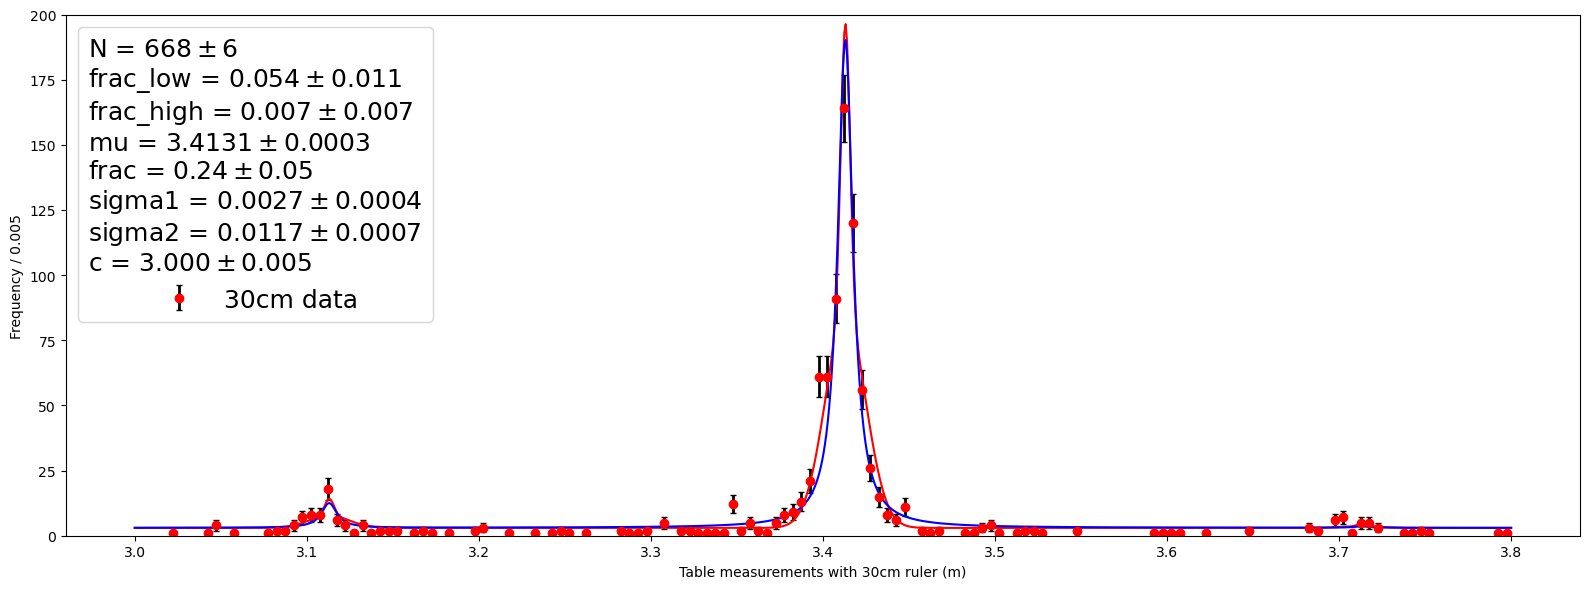

In [30]:
# Now plot the histogram with uncertainties along with the fit function:
fig5, ax5 = plt.subplots(figsize=(16,6))
ax5.errorbar(x, y, sy, label='30cm data', fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
x_axis = np.linspace(xmin, xmax, 1000)
ax5.plot(x_axis, func_G2_3peaks_const_llh(x_axis, *mllhfit_3G2c.values[:]), '-r')      # Note how we can "smartly" input the fit values!
ax5.plot(x_axis, func_Cauchy_3peaks_const(x_axis, *mllhfit_3Cauchy_c.values[:]), '-b')
ax5.set(title ="", xlabel="Table measurements with 30cm ruler (m)", ylabel="Frequency / 0.005")

# Plot the fit function on top of data with "given" parameters to check correspondence:
# ax5.plot(x_axis, func_G2_3peaks_const_llh(x_axis, 660, 0.1, 0.05, 3.41, 0.7, 0.008, 0.024, 2.5), '-b')

fit_info = []
for p, v, e in zip(mllhfit_3G2c.parameters, mllhfit_3G2c.values[:], mllhfit_3G2c.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")
ax5.legend(loc='upper left', title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
ax5.set_ylim(0.0,200.0)

# Plot the individual values at the bottom of the plot:
# ax4.plot(xmix, np.zeros_like(xmix), "|", alpha=0.1);

    
fig5.tight_layout()
if (save_plots) :
    fig5.savefig("TableMeasurements_FitAnalysis_30cm_3peaks_eachof_2gauss_const_LLHfit.pdf")

## Comparing fitting results and impact on mean and uncertainty:

In [31]:
# Fitting result comparison:
def ShowFitResultSpecifics(name, mfit, isChi2Fit=True) :
    if (isChi2Fit) :
        print(f"{name:35s} Prob(chi2 = {mfit.fval:5.1f}, Ndof = {np.sum(y > 0) - mfit.nfit}) = " +
              f"{stats.chi2.sf(mfit.fval, np.sum(y > 0) - mfit.nfit):.3f}" + 
              f"    Mu = {mfit.values['mu']:8.6f} +- {mfit.errors['mu']:8.6f}")
    else :
        print(f"{name:35s} Likelihood value = {mfit.fval:5.1f}           " + 
              f"    Mu = {mfit.values['mu']:8.6f} +- {mfit.errors['mu']:8.6f}")

ShowFitResultSpecifics("Chi2 - Single Gaussian: ", mfit_G1, True)
ShowFitResultSpecifics("Chi2 - Double Gaussian: ", mfit_G2, True)
ShowFitResultSpecifics("Chi2 - 3 x Double Gaussian: ", mfit_3G2, True)
ShowFitResultSpecifics("Chi2 - 3 x Double Gaussian + c: ", mfit_3G2c, True)
ShowFitResultSpecifics("ULLH - 3 x Double Gaussian + c: ", mllhfit_3G2c, False)
ShowFitResultSpecifics("ULLH - 3 x Cauchy + c: ", mllhfit_3Cauchy_c, False)

Chi2 - Single Gaussian:             Prob(chi2 = 117.4, Ndof = 94) = 0.052    Mu = 3.411227 +- 0.000455
Chi2 - Double Gaussian:             Prob(chi2 =  73.5, Ndof = 92) = 0.922    Mu = 3.411950 +- 0.000547
Chi2 - 3 x Double Gaussian:         Prob(chi2 = 111.9, Ndof = 90) = 0.059    Mu = 3.411138 +- 0.000452
Chi2 - 3 x Double Gaussian + c:     Prob(chi2 =  89.5, Ndof = 89) = 0.466    Mu = 3.412124 +- 0.000448
ULLH - 3 x Double Gaussian + c:     Likelihood value = -6327.9               Mu = 3.413071 +- 0.000321
ULLH - 3 x Cauchy + c:              Likelihood value = -6241.9               Mu = 3.413009 +- 0.000318


# Conclusions and comparison:

The unbinned likelihood fit is not without its complications, and it has a harder time to converge, needing some fixed values. However, it avoids the trouble of the binning, which also results in a small shift in the result. It clearly has the smallest uncertainty on the mean, and is remarkably comparable to the weighted mean result: $\mu = 3.41300 \pm 0.00027$ m.

A similar analysis could be carried out for the 2m results, but here the situation is a lot simpler, as there is in all essence only a single peak.

**Notice that even though there has been a lot of analysis, comparison, and discussion of the result, the actual value of the table length has not yet been unblinded!**

***

# Questions:

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

_Example solution 1_: Not at all precise enough! The standard deviation (i.e. estimate of single measurement precision) is more than 20 cm. Clearly, some of the measurements are very bad, ruining the "naive" mean.

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

_Example solution 2_: There are smaller but obvious peaks at +-30cm due to measurement mistakes (maybe even some at +-60cm). You can exclude them, correct them, or fit multiple Gaussians and take into account the highest peak for the table length. You can take for example 3.5 sigma as a limit (since we expect 0.4 data points there) and discard everything outside of that interval. This deletes a sizable fraction of the data points.

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

_Example solution 3_: Fitting with multiple Gaussians (or a Gaussian in a smaller range) gives a much better result. The histogram is not perfectly Gaussian, there are higher peaks for every zero'th cm, coming from people who rounded their estimate. The p-values for my Gaussian fits are not good, indicating that it might not be similar enough to a Gaussian. However, given the data and understanding that it is not perfectly continuous, we will have to live with that.

4. Once you have selected the measurements you want to use, calculate the mean, RMS and uncertainty on the mean. How much did your result improve in precision from the raw data in Q1?

_Example solution 4_: Using the tripple peak method: mean = 3.366 +/- 0.00040 and RMS = 0.003 +/- 0.00042. The improved precision in the RMS is 0.203/0.003 = a factor of 68. You would need 4624 measurements to improve that much!

5. The "Pull" distribution is defined as the plot of $z_i = \left(x_i - \mu \right)/\sigma_i$ where $\mu$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties.

_Example solution 5_: The pull distribution does not look very Gaussian. It is slightly assymetric, and there are many measurements that are a high number of sigma away from the mean. The Gaussian fit matches the distribution poorly. There are too many pull values very close to zero, indicating that people's uncertainty estimates were too large. But there are also too many outliers - people that measured wrongly and have uncertainties that are too small to reflect that.

6. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Do you need to discard more dubious measurements? Did the result improve further in precision?

_Example solution 6_: When calculating the weighted mean with all the data points, the $\chi^2$ is quite bad. When discarding the points outside of 3 sigma the result is a lot better and with a more reasonable probability.

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{mis} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.

_Example solution 7_: Pick a range within which you count measurements as too high or too low. Count the number of measurements that belong to each group; $N_{low}$ and $N_{high}$. The error on these counts is calculated by poissonian statistics: $\sqrt{N_{low}}$ and $\sqrt{N_{high}}$. Calculate the ratio of mismeasurements $r_{mis}$. The corresponding error can be found by propagating the uncertainties of $N_{low}$ and $N_{high}$. The systematic uncertainty is associated with the range you pick in which measurements are classified as mismeasurements. Determine standard deviations for your range (pick for example a tight and a loose range), and see how these uncertainties propagate into the ratio (by counting $N_{low}$ and $N_{high}$ and the corresponding $r_{mis}$, for each range). The variation in $r_{mis}$ shows a standard deviation associated with the systamatic uncertainty.<br>
A good alternative solution can be obtained from fitting, as this doesn't require you to choose any range, and you thus avoid the associated systematic uncertainty.



#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

_Example solution 8_: Compare the standard deviations from the central peak for the 30cm ruler and the 2m folding ruler case. It should not be a surprise that it is smaller for the 2m folding rule, as this is simply a better device for the measurement.

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

_Example solution 9_: Difference: abs(L30cm_weigthed_mean - L2m_weighted_mean). Uncertainty on difference: Propagate errors of the weigthed means into the difference.

Difference in number of sigmas: abs(L30cm_weigthed_mean - L2m_weighted_mean)/sqrt(eL30cm_weigthed_mean^2 + L2m_weighted_mean^2). See how far away this is from zero sigma. This is a standard z-test with two samples.

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)

_Example solution 10_: I would probably take the weighted mean (after discarding the outliers) of the 2m ruler, and be convinced further if the 30cm ruler result agrees.


### Advanced questions:

11. Consider the 2020 data files with additional information about which day the measurements were done, and find out if the day has an impact on the quality of the measurements.

12. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?

_Example solution 12_: See if there is a shift in value from the unweighted mean to the weighted mean. If the weighted mean is larger, then people with smaller uncertainties contributed slightly longer measurements of the table. There is in fact such an effect!

# Learning points:

This is a "open" and potentially long exercise, which in essense is meant to illustrate how challeging real data can be, even if it is conceptually simple and in one dimension.

The first learning point is that real data is potentially very complicated, and requires consideration/processing before being as clear cut, as what we simulate. Two approaches could be:
1. A crude/fast *"cut the non-standard (wrong?) measurements away"* analysis, potentially missing something.
2. A detailed *"plot a lot and consider every single point"*, potentially (over-?)using a lot of time.

From this exercise, you should have learned:
1. Always **start by plotting the data**, and ask yourself, if the distributions make sense.
2. In order to remove potential mis-measurements, one uses **Chauvenet's Criterion** and rejects points with a low probability of being correct.
3. Alternatively, one corrects data points (calibration) based on **understanding the reason(s) for these shifts**. 
4. Once the data has been cleaned (distributions Gaussian?), one can apply the usual calculations of mean $\mu$, Standard Deviation $\sigma$, and uncertainty on the mean $\sigma_{\mu}$.
5. When considering **data with uncertainties, the data cleaning is different**, as one considers how far away potential mis-measurements are in units of their uncertainty.
6. **It is always important to have ways of cross checking one's results**, in this case comparing the 30cm ruler with the 2m folding rule result.
7. An alternative method of estimating the length is by fitting the entire distribution with a combination of PDFs (Gaussians). In this way, one avoids excluding data, but rather model the mistakes made.